## HW02 Code

### Name: Nick Murphy

You will complete the following notebook, as described in the PDF for Homework 02 (included in the download with the starter code).  You will submit:
1. This notebook file, along with your COLLABORATORS.txt file, to the Gradescope link for code.
2. A PDF of this notebook and all of its output, once it is completed, to the Gradescope link for the PDF.  (This can be generated by printing the notebook as PDF, or using the **File -> Download as** menu.)


Please report any questions to the [class Piazza page](https://piazza.com/tufts/spring2021/comp135/home).

In [1]:
# import libraries as needed
import numpy as np
import pandas as pd
import math
import operator

from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Perceptron, Ridge
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import PolynomialFeatures

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

### Plotting function

**Do not modify the following**: it takes in a list of polynomial (integer) values, along with associated lists consisting of the predictions made for the associated model, and the resulting error, and plots the results in a grid.

In [2]:
def plot_predictions(polynomials=list(), prediction_list=list(), error_list=list()):
    '''Plot predicted results for a number of polynomial regression models
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model.
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    
        Note: it is expected that all lists are of the same length, and 
            that this length be some perfect square (for grid-plotting).
    '''
    length = len(prediction_list)
    grid_size = int(math.sqrt(length))
    if not (length == len(polynomials) and length == len(error_list)):
        raise ValueError("Input lists must be of same length")
    if not length == (grid_size * grid_size):
        raise ValueError("Need a square number of list items (%d given)" % (length))
    
    fig, axs = plt.subplots(grid_size, grid_size, figsize =(14,14), sharey=True)
    for subplot_id, prediction in enumerate(prediction_list):
        # order data for display
        data_frame = pd.DataFrame(data=[x[:, 0], prediction]).T
        data_frame = data_frame.sort_values(by=0)
        x_sorted = data_frame.iloc[:, :-1].values
        prediction_sorted = data_frame.iloc[:, 1].values

        ax = axs.flat[subplot_id]
        ax.set_title('degree = %d; MSE = %.3f' % (polynomials[subplot_id], error_list[subplot_id]))
        ax.plot(x, y, 'r.')
        ax.plot(x_sorted, prediction_sorted, color='blue')
        
    plt.show()

### Load the dataset

In [3]:
data = pd.read_csv('data.csv')
data

,x_i,y_i
0,1.590909,2.846988
1,1.803030,2.959811
2,4.984848,13.041394
3,1.696970,3.971889
4,1.272727,2.454520
...,...,...
95,5.090909,11.537465
96,10.500000,10.381492
97,1.484848,2.683212
98,0.636364,1.437600


In [4]:
x = data.iloc[:, :-1].values
y = data.iloc[:, 1].values

### 1. Test a range of polynomial functions fit to the data

Fit models to data of polynomial degree $d \in \{1, 2, 3, 4, 5, 6, 10, 11, 12\}$.  For each such model, we will record its predictions on the input data, along with the mean squared error (MSE) that it makes.  These results are then plotted for comparison.

#### 1.1 Create function to generate models, make predictions, measure error.

In [5]:
def test_polynomials(polynomials=list()):
    '''Generates a series of polynomial regression models on input data.
       Each model is fit to the data, then used to predict values of that
       input data.  Predictions and mean squared error are collected and
       returned as two lists.
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model, to be built.
    
    Returns
    -------
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    '''
    prediction_list = list()
    error_list = list()
   
    # TODO: fill in this function to generate the required set of models,
    #       returning the predictions and the errors for each.
    for deg in polynomials:
        poly = PolynomialFeatures(degree = deg) 
        x_train = poly.fit_transform(x)
        line = LinearRegression()
        line.fit(x_train,y)
        y_predict = line.predict(x_train)
        prediction_list.append(y_predict)
        error_list.append(mean_squared_error(y,y_predict))
        
    return prediction_list, error_list
    

In [6]:
# TODO: generate the sequence of degrees, call test_polynomials to create models,
#       use plot_predictions to show the results
poly = [1, 2, 3, 4, 5, 6, 10, 11, 12]
predicton_list, error_list = test_polynomials(poly)

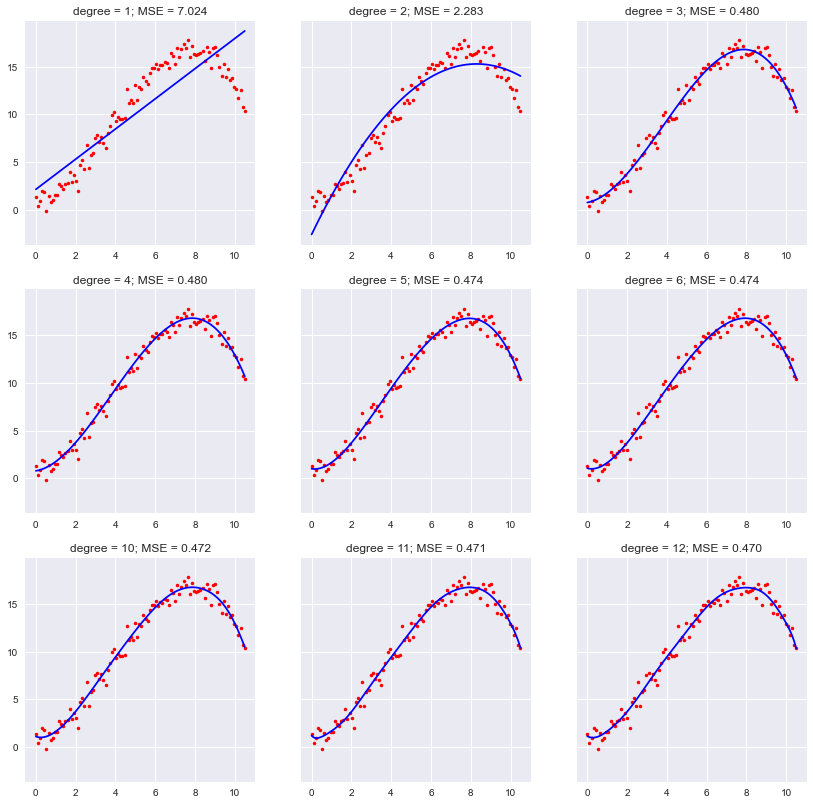

In [7]:
plot_predictions([1, 2, 3, 4, 5, 6, 10, 11, 12],predicton_list,error_list)

#### 1.2 Discuss the results seen in the plots above

**Discussion**:  The results show that increasing the degree of the model increases the accuracy of the predictions, as the lowest Mean Squared Error came from the model with degree 12. Because this model uses gradient descent, it makes sense that training error decreases as degree increases.  

### 2. $k$-fold cross-validation 

For each of the polynomial degrees, 5-fold cross-validation is performed.  Data is divided into 5 equal parts, and 5 separate models are trained and tested.  Results are averaged over the 5 runs and plotted (in a single plot), comparing training and test error for each of the polynomial degrees.  Error values are also shown in a tabular form.

#### 2.1 Creating the $k$ folds

A function that generates the distinct, non-overlapping folds of the data.

In [8]:
def make_folds(num_folds=1):
    '''Splits data into num_folds separate folds for cross-validation.
       Each fold should consist of M consecutive items from the
       original data; each fold should be the same size (we will assume 
       that  the data divides evenly by num_folds).  Every data item should 
       appear in exactly one fold.
       
       Args
       ----
       num_folds : some positive integer value
           Number of folds to divide data into.
           
        Returns
        -------
        x_folds : list of sub-sequences of original x-data 
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
        y_folds : list of sub-sequences of original y data
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
       '''
    x_folds = list()
    y_folds = list()
    foldlen = int(len(x)/num_folds)
    start = 0
    # TODO: Complete method to generate partition into folds.
    for k in range(num_folds):
        x_folds.append(x[start:start + foldlen])
        y_folds.append(y[start:start + foldlen])
        start += foldlen
    
    return x_folds, y_folds

In [9]:
# Print out start/end of each fold for sanity check.  Should see 5 folds,
# with the (x,y) pairs at the start/end of each.  (Can be manually verified 
# by looking at original input file.)
#
#
# DO NOT MODIFY THIS CODE.  Its output will be used to check your work.
#
#
k = 5
x_folds, y_folds = make_folds(k)
for i in range(k):
    print("Fold %d: (%.3f, %.3f) ... (%.3f, %.3f)"
         % (i, x_folds[i][0], y_folds[i][0], x_folds[i][-1], y_folds[i][-1]))

Fold 0: (1.591, 2.847) ... (10.394, 10.739)
Fold 1: (6.788, 16.408) ... (2.227, 4.722)
Fold 2: (9.545, 13.897) ... (3.924, 10.229)
Fold 3: (2.864, 5.929) ... (7.212, 16.030)
Fold 4: (7.530, 16.982) ... (0.848, 0.990)


#### 2.2 Perform cross-validation

For each of the polynomial degrees already considered, $k$-fold cross-validation is performed.  Average training error (MSE) and test error (MSE) are reported, both in the form of a plot and a tabular print of the values.

In [10]:
# TODO: Perform 5-fold cross-validation for each polynomial degree.  
#       Keep track of average training/test error for each degree; 
#       Plot results in a single table, properly labeled, and also
#       print out the results in some clear tabular format.

In [11]:
#Plan:
#     1. Create k folds of each dataset (above)
#     2. For each fold set:
#           a. Split folds into testing and training
#           b. Call mytest_polynomials into split set
#.          c. Get average training and test errors
#.          d. Store errors in list
#     3. Get average training and testing errors for each degree
#     4. Plot results in a table
#

In [12]:
def cat(data):
    data_final = [y for x in data for y in x]
    return data_final

In [13]:
def mytest_polynomials(polynomials,x_folds,y_folds):
    test_score = []
    train_score = []
    k = 5
    for deg in polynomials:
        test_error = 0
        train_error = 0
        for i in range(k):
            training_x = x_folds.copy()
            testing_x = training_x.pop(i)
            training_y = y_folds.copy()
            testing_y = training_y.pop(i)
            poly = PolynomialFeatures(degree = deg)
            model = LinearRegression()
            cat_X = cat(training_x)
            cat_Y = cat(training_y)
            new_X = poly.fit_transform(cat_X)
            model.fit(new_X, cat_Y)
            y_train_predict = model.predict(new_X)
            y_test_predict = model.predict(poly.fit_transform(testing_x))
            train_error += mean_squared_error(cat_Y, y_train_predict)
            test_error += mean_squared_error(testing_y, y_test_predict)
        test_score.append(test_error/k)
        train_score.append(train_error/k)  
    return test_score, train_score

In [14]:
def print_cross_in_table(trainingerr, testingerr, poly):
    d = {'Degree': poly, 'Average Testing Error': testingerr, 'Average Training Error': trainingerr}
    df = pd.DataFrame(data = d)
    print(df)

In [15]:
def cross_validate(x_folds, y_folds, polynomials=list()):
    k=5
    testingerr, trainingerr = mytest_polynomials(poly,x_folds,y_folds)
    plt.plot(poly, testingerr, color='red', label = 'Testing Error')
    plt.plot(poly, trainingerr, color='blue', label = 'Training Error')
    plt.title('K Fold Cross Validation Training Error and Testing Error')
    plt.xlabel('Degree of Polynomial')
    plt.ylabel('Average Error')
    plt.legend()
    plt.show()
    print_cross_in_table(trainingerr, testingerr, poly)

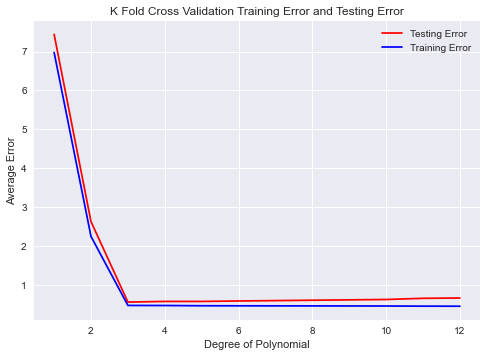

   Degree  Average Testing Error  Average Training Error
0       1               7.441157                6.977641
1       2               2.625608                2.245920
2       3               0.558083                0.471621
3       4               0.574623                0.469909
4       5               0.574580                0.463663
5       6               0.586606                0.462069
6      10               0.624748                0.457199
7      11               0.654948                0.453294
8      12               0.662501                0.451891


In [16]:
cross_validate(x_folds, y_folds, poly)

#### 2.3 Discuss the results seen in the plots above

**Discussion:** The results show that as degree increases, average training error and average testing error decrease until around degree 3, where it levels out. We see the best results at degree 3. We can see underfitting on degrees 1 and 2 as the average training and testing errors are high. I don't believe overfitting is apparent in this set of polynomials, but will be in part 3.  

### 3. Higher-order polynomials

Results are generated and plotted (as for part 1), for the higher polynomial degrees $d = \{15, 17, 19, 21, 25, 30, 35, 40, 50\}$.

#### 3.1 Plot a grid of prediction results/errors for the higher-order polynomials

In [17]:
# TODO: generate and plot 9 more models, for the higher-degree polynomials indicated.
newpoly = [15,17,19,21,25,30,35,40,50]
#testingerr, trainingerr = mytest_polynomials(poly,x_folds,y_folds)
newpred_list, newerr_list = test_polynomials(newpoly)

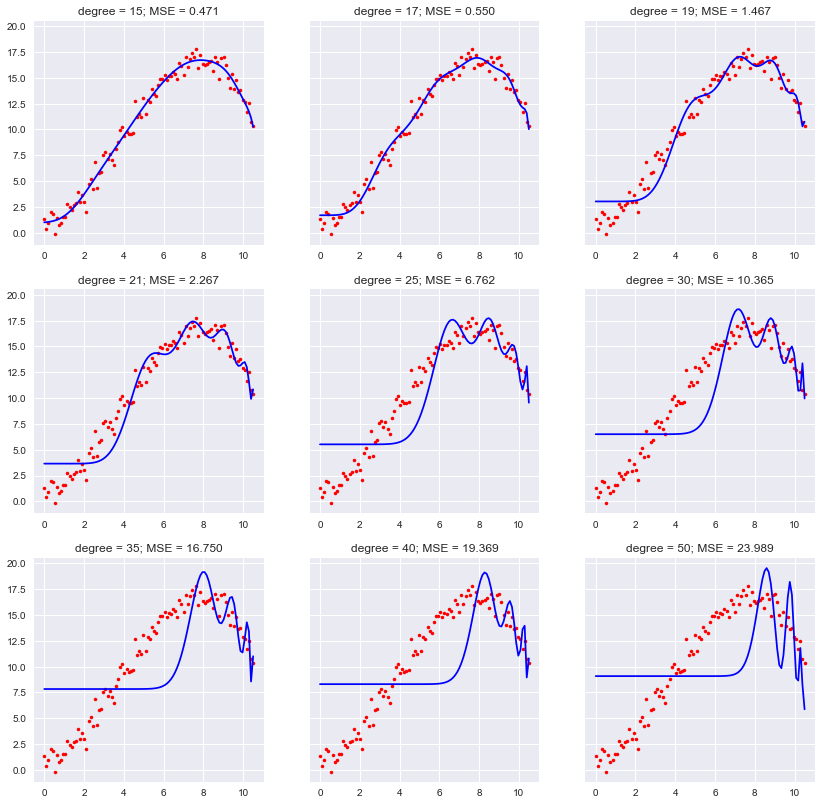

In [18]:
plot_predictions(newpoly, newpred_list, newerr_list)

#### 3.2 Discuss the results seen in the plots above

**Discussion**: These results show that we've gone too far in using high degree polynomials to fit our data, as Mean Squared Error has spiked up from Part 1.1. We see the best results with degree 15, which makes sense as it is the smallest of this set and is closest to the degrees used in Part 1.1. 

### 4. Regularized (ridge) regression

Ridge regularization is a process whereby the loss function that is minimized combines the usual measure (error on the training data) with a penalty that is applied to the magnitude of individual coefficients.  This latter penalty discourages models that overly emphasize any single feature, and can often prevent over-fitting.

Here, a set of 50 different `sklearn.linear_model.Ridge` models are generated, each using a single polynomial degree (the one that was determined to be best for the data-set in earlier tests), and using a range of different regularization penalties, chosen from a logarithmic series: $s \in [0.01, 100]$.  5-fold cross-validation is again used to examine how robust these models are.

#### 4.1 Cross-validation for each regularization strength value

In [19]:
# TODO: Generate a sequence of 50 ridge models, varying the regularization strength
#       from 0.01 (10^-2) to 100 (10^2).  Each model is 5-fold cross-validated and
#       the resulting average training/test errors are tracked.  Errors are then
#       plotted (on a logarithmic scale) and printed in some legible tabular form.

In [33]:
def ridge_polynomials(x_folds, y_folds, deg, regularization):
    test_score = []
    train_score = []
    k = 5
    for alpha in regularization:
        test_error = 0
        train_error = 0
        for i in range(k):
            training_x = x_folds.copy()
            testing_x = training_x.pop(i)
            training_y = y_folds.copy()
            testing_y = training_y.pop(i)
            poly = PolynomialFeatures(degree = deg)
            ridgemodel = Ridge(alpha)
            cat_X = cat(training_x)
            cat_Y = cat(training_y)
            new_X = poly.fit_transform(cat_X)
            ridgemodel.fit(new_X, cat_Y)
            y_train_predict = ridgemodel.predict(new_X)
            y_test_predict = ridgemodel.predict(poly.fit_transform(testing_x))
            train_error += mean_squared_error(cat_Y, y_train_predict)
            test_error += mean_squared_error(testing_y, y_test_predict)
        test_score.append(test_error/k)
        train_score.append(train_error/k)  
    return test_score, train_score

In [47]:
def print_cross_in_table(ridge_train_err, ridge_test_err):
    reg = np.logspace(-2,2,base=10,num=50)
    d = {'Regularization Strength': reg, 'Average Testing Error': ridge_test_err, 'Average Training Error': ridge_train_err}
    df = pd.DataFrame(data = d)
    print(df)

In [48]:
def cross_ridge_validation(degree):
    regularization = np.logspace(-2, 2, base=10, num=50)
    ridge_train_err, ridge_test_err = ridge_polynomials(x_folds, y_folds, degree, regularization)
    plt.xscale('log')
    plt.plot(regularization,ridge_train_err, color='purple',label = "Training Error")
    plt.plot(regularization,ridge_test_err, color='orange', label = "Testing Error")
    plt.title('Ridge Regression with degree ' + str(degree))
    plt.xlabel('Regulization Strength')
    plt.ylabel('Average Error')
    plt.legend()
    plt.show()
    print_cross_in_table(ridge_train_err, ridge_test_err)

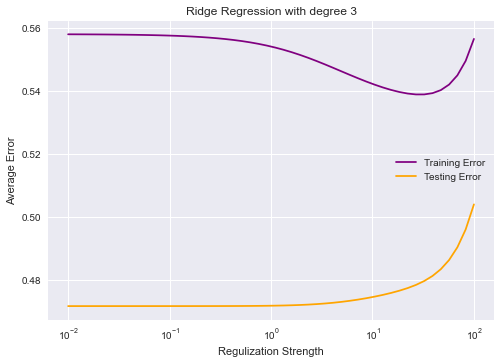

    Regularization Strength  Average Testing Error  Average Training Error
0                  0.010000               0.471621                0.558036
1                  0.012068               0.471621                0.558026
2                  0.014563               0.471621                0.558015
3                  0.017575               0.471621                0.558001
4                  0.021210               0.471621                0.557984
5                  0.025595               0.471621                0.557963
6                  0.030888               0.471621                0.557939
7                  0.037276               0.471621                0.557909
8                  0.044984               0.471621                0.557873
9                  0.054287               0.471621                0.557831
10                 0.065513               0.471621                0.557779
11                 0.079060               0.471622                0.557717
12                 0.0954

In [52]:
cross_ridge_validation(3)

#### 4.2 Discuss the results seen in the plots above

**Discussion**:  I chose to use a degree of 3 because it displayed the best results as shown in part 2.2. These results show that increasing regularization strength did not counter overfitting at degree 3 because testing error increased while training error decreased. This is apparent in both the plot and table through all of the strengths. 